<a href="https://colab.research.google.com/github/felizzi/Pdf_extractor_clinical/blob/main/Pdf_extractor_docling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install docling-core
!pip install docling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.8/96.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.15.1
    Uninstalling typer-0.15.1:
      Successfully uninstalled typer-0.15.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.7/145.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 19.5 MB

In [4]:
import logging
import time
from pathlib import Path

In [5]:
from docling_core.types.doc import ImageRefMode, PictureItem, TableItem

In [6]:
from docling.datamodel.base_models import FigureElement, InputFormat, Table
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.document_converter import DocumentConverter, PdfFormatOption

In [8]:
_log = logging.getLogger(__name__)

In [9]:
IMAGE_RESOLUTION_SCALE = 2.0

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
## print current directory


# Define the path to your PDF in Google Drive
# Assuming your file is in the "Docling_Test" folder in your Drive
google_drive_path = '/content/drive/My Drive/Docling_Test/slamon-et-al-2024-overall-survival-with-palbociclib-plus-letrozole-in-advanced-breast-cancer.pdf'

# Create a local output directory
output_dir = Path("scratch")
output_dir.mkdir(exist_ok=True)

# Copy the file from Google Drive to local storage
local_pdf_path = output_dir / "slamon-et-al-2024.pdf"
if not local_pdf_path.exists():
    import shutil
    shutil.copy2(google_drive_path, local_pdf_path)

# Now use the local path in your code
input_doc_path = local_pdf_path

In [17]:
print(input_doc_path)

scratch/slamon-et-al-2024.pdf


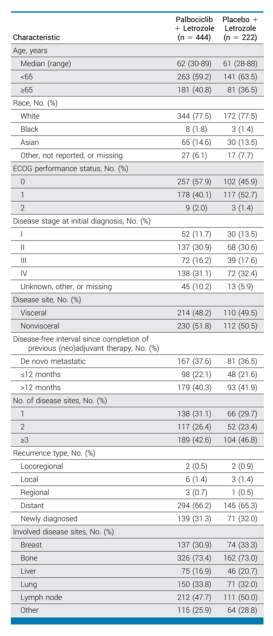

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Display an image from the scratch folder
img = mpimg.imread('scratch/slamon-et-al-2024-table-1.png')
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

In [20]:
## list the content of the folder scratch
!ls scratch

slamon-et-al-2024-1.png		 slamon-et-al-2024-picture-4.png
slamon-et-al-2024-2.png		 slamon-et-al-2024-picture-5.png
slamon-et-al-2024-3.png		 slamon-et-al-2024-picture-6.png
slamon-et-al-2024-4.png		 slamon-et-al-2024-picture-7.png
slamon-et-al-2024-5.png		 slamon-et-al-2024-picture-8.png
slamon-et-al-2024-6.png		 slamon-et-al-2024-table-1.png
slamon-et-al-2024-7.png		 slamon-et-al-2024-table-2.png
slamon-et-al-2024-8.png		 slamon-et-al-2024-table-3.png
slamon-et-al-2024-9.png		 slamon-et-al-2024-with-image-refs_artifacts
slamon-et-al-2024.pdf		 slamon-et-al-2024-with-image-refs.html
slamon-et-al-2024-picture-1.png  slamon-et-al-2024-with-image-refs.md
slamon-et-al-2024-picture-2.png  slamon-et-al-2024-with-images.md
slamon-et-al-2024-picture-3.png


In [18]:
def main():
    logging.basicConfig(level=logging.INFO)

    #input_doc_path = Path("./Docling_Test/slamon-et-al-2024-overall-survival-with-palbociclib-plus-letrozole-in-advanced-breast-cancer.pdf")
    #output_dir = Path("scratch")

    # Important: For operating with page images, we must keep them, otherwise the DocumentConverter
    # will destroy them for cleaning up memory.
    # This is done by setting PdfPipelineOptions.images_scale, which also defines the scale of images.
    # scale=1 correspond of a standard 72 DPI image
    # The PdfPipelineOptions.generate_* are the selectors for the document elements which will be enriched
    # with the image field
    pipeline_options = PdfPipelineOptions()
    pipeline_options.images_scale = IMAGE_RESOLUTION_SCALE
    pipeline_options.generate_page_images = True
    pipeline_options.generate_picture_images = True

    doc_converter = DocumentConverter(
        format_options={
            InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
        }
    )

    start_time = time.time()

    conv_res = doc_converter.convert(input_doc_path)

    output_dir.mkdir(parents=True, exist_ok=True)
    doc_filename = conv_res.input.file.stem

    # Save page images
    for page_no, page in conv_res.document.pages.items():
        page_no = page.page_no
        page_image_filename = output_dir / f"{doc_filename}-{page_no}.png"
        with page_image_filename.open("wb") as fp:
            page.image.pil_image.save(fp, format="PNG")

    # Save images of figures and tables
    table_counter = 0
    picture_counter = 0
    for element, _level in conv_res.document.iterate_items():
        if isinstance(element, TableItem):
            table_counter += 1
            element_image_filename = (
                output_dir / f"{doc_filename}-table-{table_counter}.png"
            )
            with element_image_filename.open("wb") as fp:
                element.get_image(conv_res.document).save(fp, "PNG")

        if isinstance(element, PictureItem):
            picture_counter += 1
            element_image_filename = (
                output_dir / f"{doc_filename}-picture-{picture_counter}.png"
            )
            with element_image_filename.open("wb") as fp:
                element.get_image(conv_res.document).save(fp, "PNG")

    # Save markdown with embedded pictures
    md_filename = output_dir / f"{doc_filename}-with-images.md"
    conv_res.document.save_as_markdown(md_filename, image_mode=ImageRefMode.EMBEDDED)

    # Save markdown with externally referenced pictures
    md_filename = output_dir / f"{doc_filename}-with-image-refs.md"
    conv_res.document.save_as_markdown(md_filename, image_mode=ImageRefMode.REFERENCED)

    # Save HTML with externally referenced pictures
    html_filename = output_dir / f"{doc_filename}-with-image-refs.html"
    conv_res.document.save_as_html(html_filename, image_mode=ImageRefMode.REFERENCED)

    end_time = time.time() - start_time

    _log.info(f"Document converted and figures exported in {end_time:.2f} seconds.")

In [19]:
if __name__ == "__main__":
    main()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
